# Model comparison

To demonstrate the use of model comparison criteria in PyMC 3, we implement the **8 schools** example from Section 5.5 of Gelman et al (2003), which attempts to infer the effects of coaching on SAT scores of students from 8 schools. Below, we fit a **pooled model**, which assumes a single fixed effect across all schools, and a **hierarchical model** that allows for a random effect that partially pools the data.

In [1]:
%matplotlib inline
from pymc3 import (Normal, HalfCauchy, sample, Model, waic, dic, loo, forestplot, 
                   traceplot, NUTS, find_MAP, Deterministic, HalfCauchy)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

The data include the observed treatment effects and associated standard deviations in the 8 schools.

In [2]:
J = 8
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18])

### Pooled model

In [3]:
with Model() as pooled:
    
    mu = Normal('mu', 0, sd=1e6)
    
    obs = Normal('obs', mu, sd=sigma, observed=y)

In [4]:
with pooled:
    trace_p = sample(2000)

100%|██████████| 2000/2000 [00:00<00:00, 2385.73it/s]


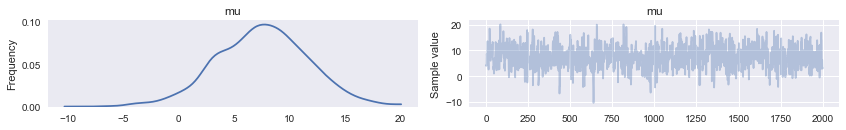

In [5]:
traceplot(trace_p, varnames=['mu']);

### Hierarchical model

In [6]:
with Model() as hierarchical:
    
    eta = Normal('eta', 0, 1, shape=J)
    mu = Normal('mu', 0, sd=1e6)
    tau = HalfCauchy('tau', 5)
    
    theta = Deterministic('theta', mu + tau*eta)
    
    obs = Normal('obs', theta, sd=sigma, observed=y)

In [7]:
with hierarchical:
    trace_h = sample(2000)

100%|██████████| 2000/2000 [00:02<00:00, 706.05it/s]


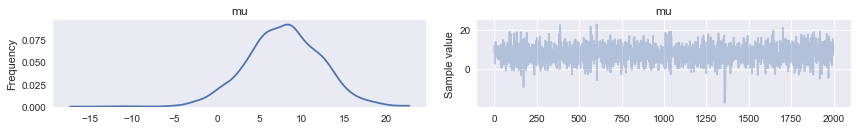

In [8]:
traceplot(trace_h, varnames=['mu']);

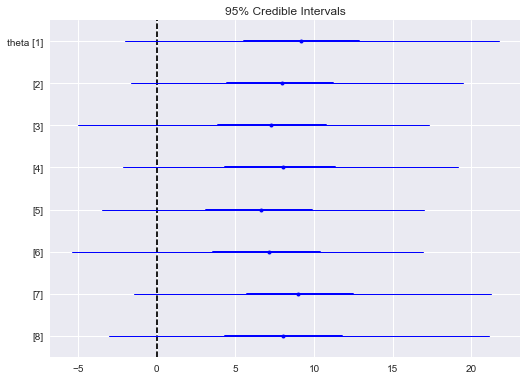

In [9]:
forestplot(trace_h, varnames=['theta']);

### Deviance Information Criterion (DIC)

DIC (Spiegelhalter et al. 2002) is an information theoretic criterion for estimating predictive accuracy that is analogous to Akaike's Information Criterion (AIC). It is a more Bayesian approach that allows for the modeling of random effects, replacing the maximum likelihood estimate with the posterior mean and using the effective number of parameters to correct for bias.

In [10]:
with pooled:
    pooled_dic = dic(trace_p)
    
pooled_dic

90.925442023139937

In [11]:
with hierarchical:
    hierarchical_dic = dic(trace_h)
    
hierarchical_dic

124.4586578158235

### Widely-applicable Information Criterion (WAIC)

WAIC (Watanabe 2010) is a fully Bayesian criterion for estimating out-of-sample expectation, using the computed log pointwise posterior predictive density (LPPD) and correcting for the effective number of parameters to adjust for overfitting.

In [12]:
with pooled:
    pooled_waic = waic(trace_p)
    
pooled_waic.WAIC

61.207200231982306

In [13]:
with hierarchical:
    hierarchical_waic = waic(trace_h)
    
hierarchical_waic.WAIC

61.343846074554747

For WAIC PyMC3 reports a point estimate together with its standard error. The standard error can be useful to assess the uncertainty of the WAIC estimates. Nevertheless, caution need to be taken because the estimation of the standard error assumes normality and hence could be problematic when the sample size is low.

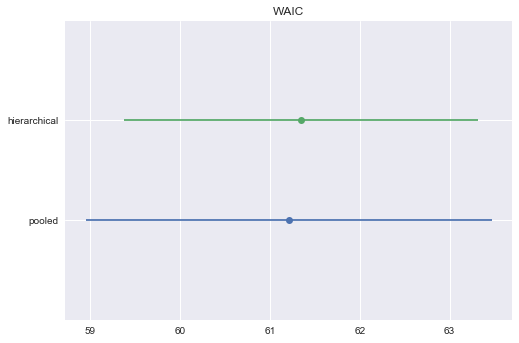

In [14]:
plt.errorbar(pooled_waic.WAIC, 0, xerr=pooled_waic.WAIC_se, fmt='o')
plt.errorbar(hierarchical_waic.WAIC, 1, xerr=hierarchical_waic.WAIC_se, fmt='o')
plt.title('WAIC')
plt.yticks(np.arange(0, 2), ('pooled', 'hierarchical'))
plt.ylim(-1, 2);

### Leave-one-out Cross-validation (LOO)

LOO cross-validation is an estimate of the out-of-sample predictive fit. In cross-validation, the data are repeatedly partitioned into training and holdout sets, iteratively fitting the model with the former and evaluating the fit with the holdout data. Vehtari et al. (2016) introduced an efficient computation of LOO from MCMC samples, which are corrected using Pareto-smoothed importance sampling (PSIS) to provide an estimate of pointwise out-of-sample prediction accuracy.

In [15]:
with pooled:
    pooled_loo= loo(trace_p)
    
pooled_loo.LOO

/home/osvaldo/anaconda3/lib/python3.5/site-packages/pymc3/stats.py:208: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


61.53782737562031

In [16]:
with hierarchical:
    hierarchical_loo  = loo(trace_h)
    
hierarchical_loo.LOO

/home/osvaldo/anaconda3/lib/python3.5/site-packages/pymc3/stats.py:208: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


61.385652284361953

For LOO we can also make a similar plot to the one we did for WAIC

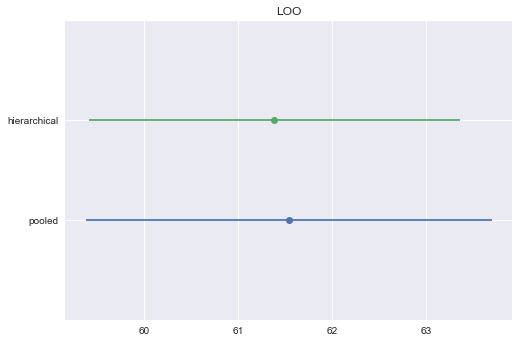

In [17]:
plt.errorbar(pooled_loo.LOO, 0, xerr=pooled_loo.LOO_se, fmt='o')
plt.errorbar(hierarchical_loo.LOO, 1, xerr=hierarchical_loo.LOO_se, fmt='o')
plt.title('LOO')
plt.yticks(np.arange(0, 2), ('pooled', 'hierarchical'))
plt.ylim(-1, 2);

### Interpretation

Though we might expect the hierarchical model to outperform a complete pooling model, there is little to choose between the models in this case, with the pooling model actually providing the best average predictive performance.

## Reference

[Gelman, A., Hwang, J., & Vehtari, A. (2014). Understanding predictive information criteria for Bayesian models. Statistics and Computing, 24(6), 997–1016.](http://doi.org/10.1007/s11222-013-9416-2)